Deep Learning Trilha 4

Aluno: Bernardo Camargo Silva


Nesta tarefa você deve implementar um modelo de classificação binária ou multiclasse para um conjunto de dados de seu interesse. O resultado do seu modelo deve ser acima de 0.8 de acuracidade sobre o conjunto de teste (0.3 dos dados de treinamento). 
 
Antes de começar, selecione uma base de dados. Você deve compartilhar as informações da base empregada (nome, descrição, link) para que não haja bases repetidas entre os seus colegas. (O professor irá prover uma área compartilhada para isso).
 
Você deve implementar o seu modelo com o Keras TensorFlow empregando o modelo fornecido de código. Quaisquer modos de programação, Modelo Sequencial, API Funcional ou Sub Classes, podem ser igualmente empregados. Seu modelo deve apresentar, no mínimo, 0.8 de acuracidade.
 
Ao final, apresente suas conclusões.



Enviar a atividade em .pdf juntamente com o endereço do Python notebook 100% executável.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

In [2]:
def display_acc_hist(history):
  history_df = pd.DataFrame(history.history)
  display(history_df.head())
  # Start the plot at epoch 0
  history_df.loc[0:, ['loss', 'val_loss']].plot()
  history_df.loc[0:, ['accuracy', 'val_accuracy']].plot()

  print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_accuracy'].max()))
  return

def display_binary_acc_hist(history):
  history_df = pd.DataFrame(history.history)
  display(history_df.head())
  # Start the plot at epoch 0
  history_df.loc[0:, ['loss', 'val_loss']].plot()
  history_df.loc[0:, ['binary_accuracy', 'val_binary_accuracy']].plot()

  print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))
  return



def print_results(y_test, y_pred):
  print('Matriz de Confusão: \n' , confusion_matrix(y_test, y_pred))
  print(classification_report(y_test, y_pred))
  print('Acuracidade: ' , accuracy_score(y_test, y_pred))
  return

In [3]:
# Explorando os dados
train = pd.read_csv('titanic_train.csv')
display(train.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<AxesSubplot:>

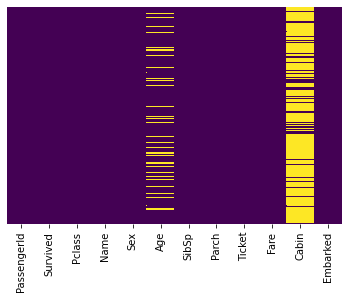

In [4]:
#Verificar campos nulos
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

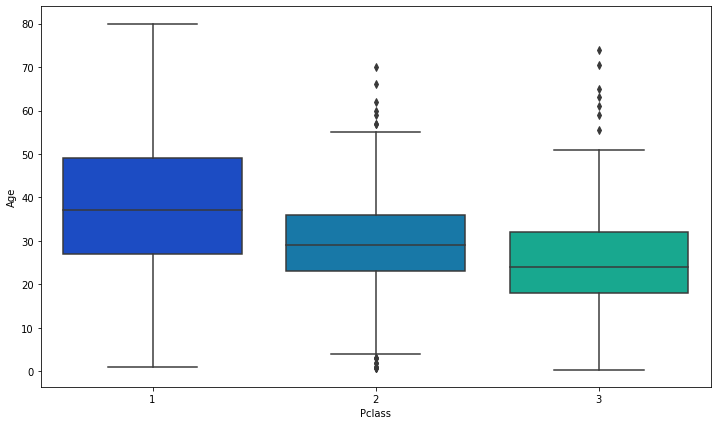

In [5]:
#Vamos verificar a média de idade por classe da cabine
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

In [6]:
#Vamos agora preencher os campos nulos da idade baseados em algum padrão
#Definindo uma função para retornar a idade baseado na classe

def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]   
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24
    else:
        return Age

#E vamos aplicar esta idade nos campos nulos
train['Age'] = train[['Age','Pclass']].apply(impute_age,axis=1)

<AxesSubplot:>

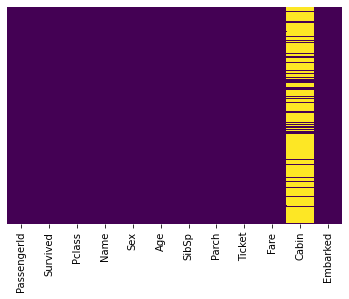

In [7]:
#Verificando novamente no dataset se há campos nulos
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [8]:
#Vamos remover a coluna da cabine, que é composta, em grande parte, de dados nulos.
train.drop('Cabin',axis=1,inplace=True)

#Removendo também quaisquer linhas que possuam colunas com valor nulo.
train.dropna(inplace=True)

In [9]:
#Verificando o dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


In [10]:
# One Hot Encoding dos campos categóricos
sex = pd.get_dummies(train['Sex'],drop_first=True)
#embark = pd.get_dummies(train['Embarked'],drop_first=True)
#age = pd.get_dummies(train['Age'],drop_first=True)

#Concatenar as colunas discretizadas pelo one hot encoding de volta no dataset
train = pd.concat([train,sex],axis=1)
#train = pd.concat([train,sex,embark],axis=1)
#train = pd.concat([train,sex,embark,age],axis=1)

In [11]:
#Remover as colunas já discretizadas SEX e EMBARKED
#Remover também outras colunas que não serão utilizadas
#train.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)
train.drop(['PassengerId','Sex','Embarked','Name','Ticket','Fare','SibSp','Parch'],axis=1,inplace=True)
#train.drop(['Sex','Embarked','Name','Ticket','Fare','Age'],axis=1,inplace=True)

In [12]:
#Visualizando, novamente, o dataset após o tratamento
train.head()

,Survived,Pclass,Age,male
0,0,3,22.0,1
1,1,1,38.0,0
2,1,3,26.0,0
3,1,1,35.0,0
4,0,3,35.0,1


In [13]:
X = scale(train.drop(columns=['Survived']))
X

array([[ 0.82520863, -0.53167023,  0.73534203],
       [-1.57221121,  0.68023223, -1.35991138],
       [ 0.82520863, -0.22869462, -1.35991138],
       ...,
       [ 0.82520863, -0.38018243, -1.35991138],
       [-1.57221121, -0.22869462,  0.73534203],
       [ 0.82520863,  0.22576881,  0.73534203]])

In [14]:
#Separando as colunas para treino da coluna target (Survived)
#X = train.drop('Survived',axis=1)
y = train['Survived']
y

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 889, dtype: int64

In [15]:
# Separando as amostras em Treinamento e Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

#y_train = np.asarray(train_labels).astype('float32').reshape((-1,1))
#y_test = np.asarray(test_labels).astype('float32').reshape((-1,1))

In [16]:
y_test

608    1
881    0
40     0
809    1
661    0
      ..
731    0
671    0
655    0
64     0
28     1
Name: Survived, Length: 267, dtype: int64

In [17]:
# Definindo o Modelo
model = keras.Sequential(layers.Dense(X.shape[1], activation='relu', input_shape=[X.shape[1]]))


model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 3)                 12        
_________________________________________________________________
dense_1 (Dense)              (None, 20)                80        
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 168       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 269
Trainable params: 269
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
# Compilando o Modelo - usando o binary_crossentropy pois o resultado esperado é binário
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])


In [ ]:
# Treina o Modelo
early_stopping = keras.callbacks.EarlyStopping(
    patience=100,
    min_delta=0.0001,
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    batch_size=32,
    validation_split=0.3,
    epochs=200,
    callbacks=[early_stopping],
    verbose=1,  
)


,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.724648,0.393103,0.711383,0.566845
1,0.699141,0.572414,0.684003,0.657754
2,0.680449,0.620690,0.665190,0.721925
3,0.667480,0.652874,0.651964,0.743316
4,0.656406,0.675862,0.637956,0.770053


Best Validation Loss: 0.4051
Best Validation Accuracy: 0.8182


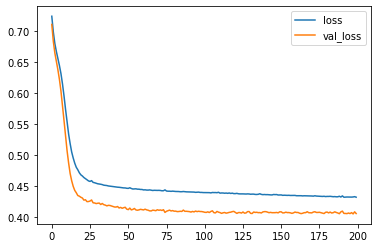

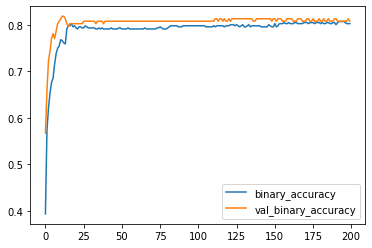

In [20]:

#display_acc_hist(history)
display_binary_acc_hist(history)

In [21]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
print('\nTest accuracy:', test_acc)

9/9 - 0s - loss: 0.4409 - binary_accuracy: 0.8015

Test accuracy: 0.8014981150627136


In [34]:
predictions = (model.predict(X_test) > 0.5).astype("int32")

In [ ]:
#Verificando as predições com os valores esperados
for i in range(267):
    print('%s => Predição: %d Esperado: %d)' % (X_test[i], predictions[i], y_test.array[i]))

In [ ]:
#X = scale(train.drop(columns=['Survived']))
X_test

In [149]:
#[CLASSE, IDADE, HOMEM]
#Classe = 1, 2 ou 3
#Idade = 0 a 100 anos
#Homem = 0 ou 1
dados_novos = scale([[3, 30, 1],[3, 30, 1],[1, 30, 1]])
#dados_novos = [[3, 30, 1],[2, 30, 1],[1, 60, 1]]

In [150]:
dados_novos

array([[ 0.70710678,  0.        ,  0.        ],
       [ 0.70710678,  0.        ,  0.        ],
       [-1.41421356,  0.        ,  0.        ]])

In [151]:
predictions_2 = (model.predict(dados_novos) > 0.5).astype("int32")

In [152]:
#Verificando as predições com os valores esperados
#0 = Morreu
#1 - Sobreviveu
for i in range(3):
    print('Predição: %d' % (predictions_2[i]))

Predição: 0
Predição: 0
Predição: 1
